In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
        
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df = pd.DataFrame(report)
df

,cost_filter,cost_nft_transfer,cost_create_var,cost_analysis_iterable_func,cost_fold,cost_analysis_check_let,cost_analysis_type_lookup,cost_secp256k1recover,cost_contract_storage,cost_index_of,cost_user_function_application,cost_ft_balance,cost_trait_checker,cost_create_ft,cost_analysis_get_function_entry,cost_nft_owner,cost_nft_mint,cost_fetch_var,cost_nft_burn,cost_unwrap_err,cost_stx_balance,cost_le,cost_type_parse_step,cost_contract_of,cost_inner_type_check_cost,cost_eq,cost_hash160,cost_some_cons,cost_as_max_len,cost_analysis_type_check,cost_analysis_lookup_variable_const,cost_if,cost_ft_get_supply,cost_analysis_check_tuple_merge,cost_is_okay,cost_leq,cost_unwrap_err_or_ret,cost_mul,cost_analysis_type_annotate,cost_analysis_tuple_items_check,cost_keccak256,cost_int_cast,cost_at_block,cost_analysis_use_trait_entry,cost_fetch_entry,cost_tuple_cons,cost_asserts,cost_div,cost_default_to,cost_not,cost_lookup_function,cost_analysis_check_tuple_get,cost_create_nft,cost_principal_of,cost_contract_call,poison_microblock,cost_pow,cost_sha256,cost_unwrap_ret,cost_ast_parse,cost_analysis_check_tuple_cons,cost_load_contract,cost_xor,cost_tuple_merge,cost_mod,cost_analysis_lookup_function_types,cost_analysis_lookup_variable_depth,cost_append,cost_geq,cost_is_err,cost_print,cost_analysis_list_items_check,cost_try_ret,cost_lookup_variable_size,cost_sha512t256,cost_analysis_option_cons,cost_set_var,cost_analysis_bind_name,cost_log2,cost_analysis_visit,cost_or,cost_match,cost_ft_transfer,cost_begin,cost_secp256k1verify,cost_type_checker,cost_read_only,cost_analysis_lookup_function,cost_concat,cost_ft_mint,cost_err_cons,cost_set_entry,cost_len,cost_ast_cycle_detection,cost_ft_burn,cost_analysis_storage,cost_ge,cost_lookup_variable_depth,cost_is_some,cost_sqrti,cost_list_cons,cost_analysis_option_check,cost_let,cost_ok_cons,cost_sha512,cost_map,cost_block_info,cost_unwrap,cost_and,cost_add,cost_is_none,cost_stx_transfer,cost_arithmetic_only_checker,cost_tuple_get,cost_element_at,cost_create_map,cost_sub
1,207191.485536,2.720600e+05,9.189084e+05,4997.403131,217696.843275,5521.439319,5261.539902,6.454821e+06,3.606368e+06,NaN,1.027136e+04,246586.689663,NaN,NaN,NaN,4.023991e+05,2.621000e+05,NaN,2.452995e+05,118961.878303,623632.786486,NaN,2328.367432,6.030009e+06,10315.990953,69888.251146,NaN,NaN,213786.024101,2.846488e+03,6884.541316,90400.02507,217556.755914,3.043059e+04,129418.788697,NaN,152856.97282,76212.821562,2548.913793,27402.346520,NaN,73916.367236,94756.915288,NaN,NaN,1.013364e+05,71326.541098,75922.846167,112346.142541,73177.65841,NaN,359.007651,6.922304e+05,NaN,69001.916318,13305632.5,NaN,NaN,134705.09375,128727805.5,6.855650e+03,NaN,NaN,NaN,NaN,NaN,8054.799599,1.114903e+05,NaN,127016.535967,NaN,2868.628828,115518.541206,5242.975862,NaN,2926.598374,NaN,63809.907407,72481.431191,288.07184,69249.401148,128957.367142,252099.132447,NaN,6093372.875,NaN,NaN,NaN,1.439235e+05,740655.56812,NaN,NaN,219085.188889,7.549626e+04,275530.462798,NaN,NaN,8243.325335,100552.103379,75506.161181,8.141956e+04,1502.686665,1.227503e+05,NaN,NaN,1.590255e+06,2.844857e+06,128103.193576,68954.676720,74594.772362,95686.968165,643761.899756,NaN,5.581900e+04,278975.325204,NaN,74989.137339
32,NaN,4.380165e+05,1.110922e+06,40747.532640,NaN,33093.047670,20558.831536,NaN,3.795940e+06,NaN,3.528912e+05,NaN,NaN,NaN,NaN,4.285451e+05,4.614488e+05,NaN,4.347176e+05,NaN,NaN,NaN,NaN,NaN,41380.430645,196656.096552,NaN,NaN,NaN,2.257902e+05,NaN,NaN,NaN,5.149719e+05,NaN,NaN,NaN,NaN,31182.045773,51829.134493,NaN,NaN,NaN,NaN,NaN,9.782315e+05,NaN,NaN,NaN,NaN,NaN,4574.033952,7.623705e+05,NaN,NaN,NaN,NaN,NaN,NaN,132479356.0,2.645457e+05,NaN,NaN,NaN,NaN,NaN,47183.268288,4.489708e+05,NaN,NaN,NaN,26391.173317,NaN,33527.728341,NaN,NaN,NaN,115280.213235,NaN,NaN,116994.446458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.614854e+05,NaN,NaN,NaN,NaN,2.041225e+06,NaN,77778.171710,NaN,47874.043190,NaN,NaN,3.157522e+05,NaN,1.478297e+06,NaN,NaN,1.986213e+07,NaN,NaN,116149.870055,NaN,NaN,NaN,NaN,6.645281e+05,NaN,N

In [3]:
def estimate_params(df, name, transform):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    X = transform(X)
#     Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b, transform):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    X = transform(X)
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output, transform = lambda x: x):
    a, b = estimate_params(df, fun_name, transform)
    print(a, b)
#     output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    if not isinstance(a, int):
        a = a.squeeze()
    if not isinstance(b, int):
        b = b.squeeze()
    output.loc[fun_name] = [a, b]
    plot(df, fun_name, a, b, transform)

[834.0938958] 4395.659788358156


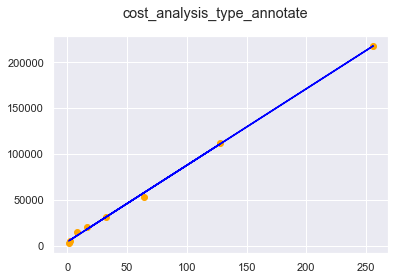

[51078.28443778] 0


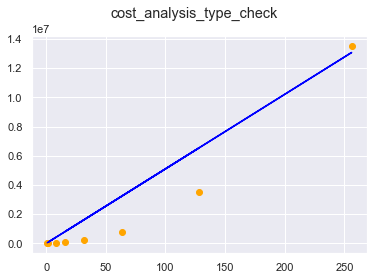

[690.19116592] 2937.321828653505


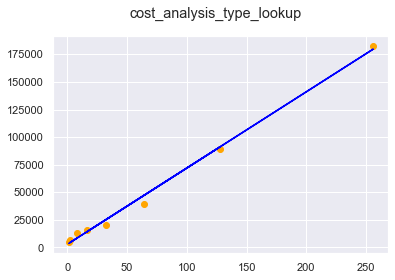

[0.] 288.07184014958364


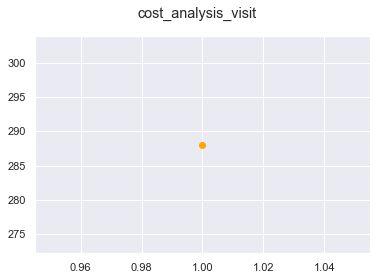

[979.92287357] 6716.682603116678


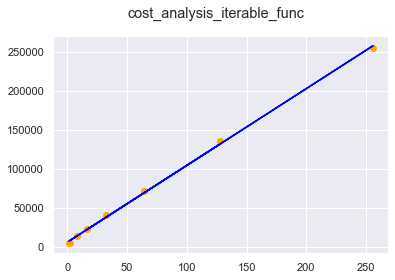

[0.] 2926.5983741952496


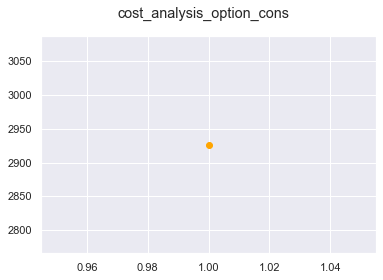

[0.] 1502.6866652879976


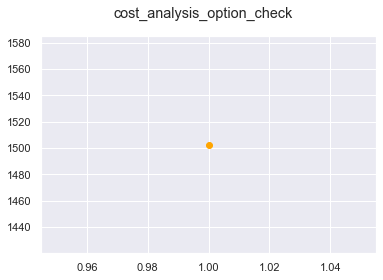

[1144.36396156] 79579.80751508565


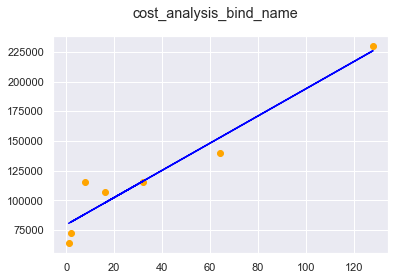

[925.34832759] 2191.2888345581523


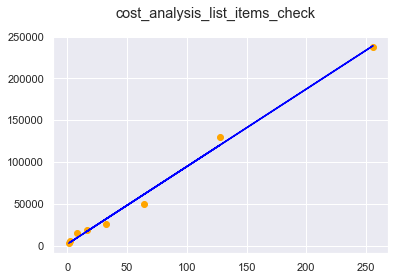

[17.92700454] 1184.0843860542618


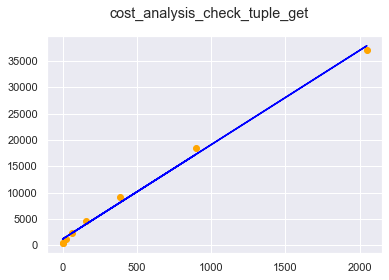

[1494.48695766] 2271.4782317341305


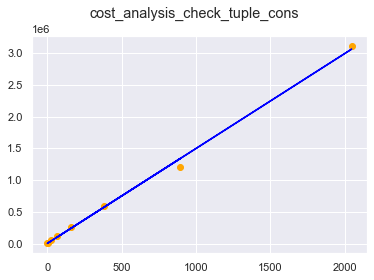

[896.81071958] 26927.83119030683


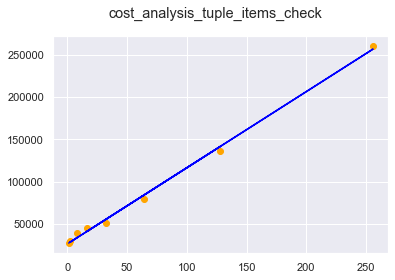

[819.32362848] 5407.291617889467


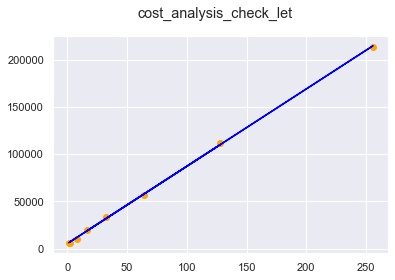

[0.] 9034.155256634029


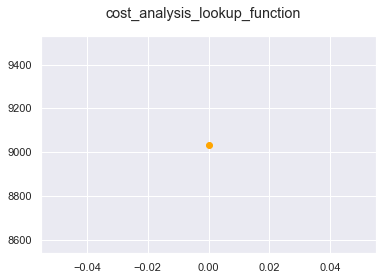

[785.0119444] 12635.934287094227


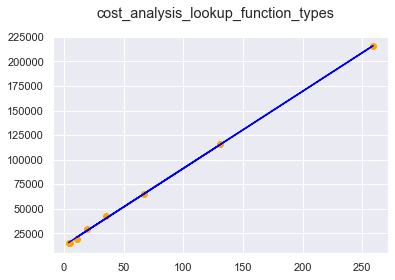

[0.] 6884.541315948503


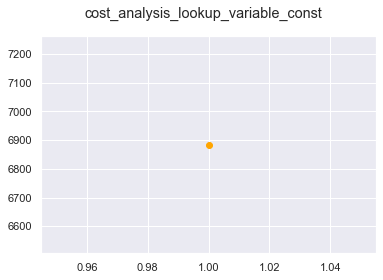

[163.44671891] 15732.099033286795


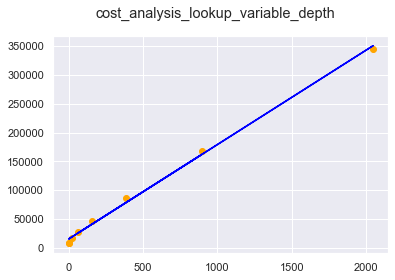

[129.30254036] 3298.4199824993266


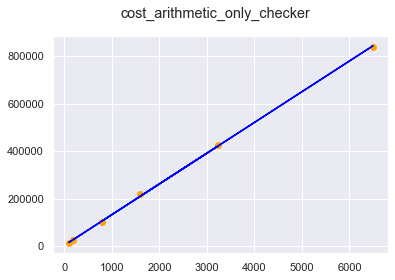

[401.01225312] [2259757.98774688]


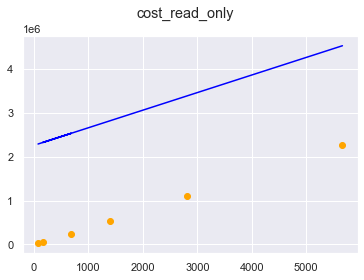

[37769.27221615] [173838.54089361]


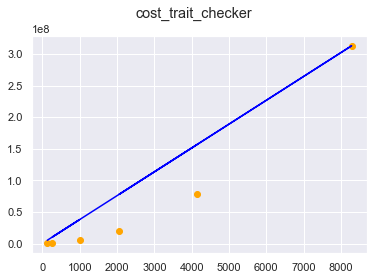

[26922.48624955] [820876.00459552]


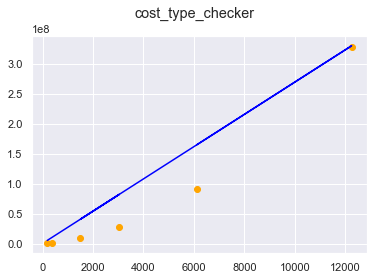

[77670.4915077] 129348879.72569935


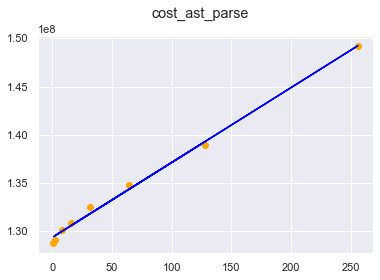

[63719.10225596] 32668.31268347986


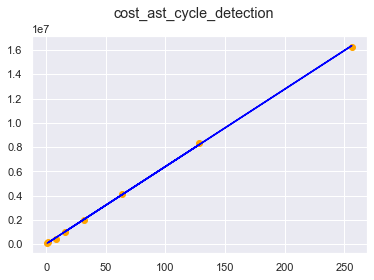

[929.97178873] 45058.22997973589


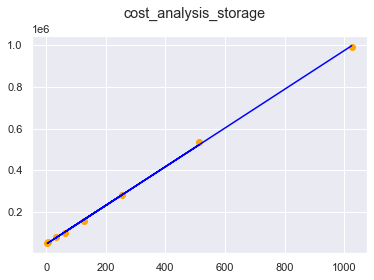

[4491.7881358] 325662.6314666005


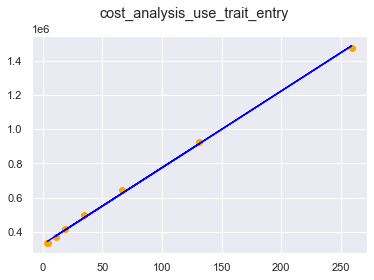

[36704.62396997] 586775.0886776145


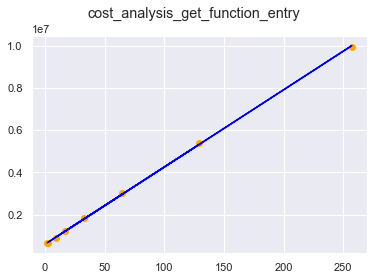

[1287.26543481] 6673.789875938135


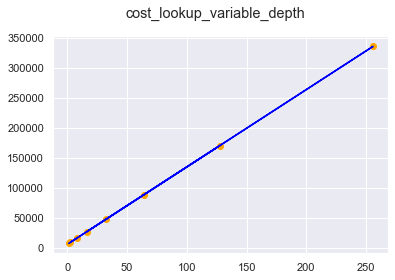

[1063.51866505] 143.42780512591708


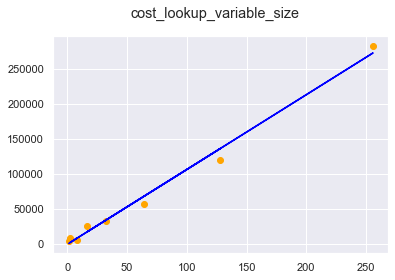

[0.] 7431.008619356833


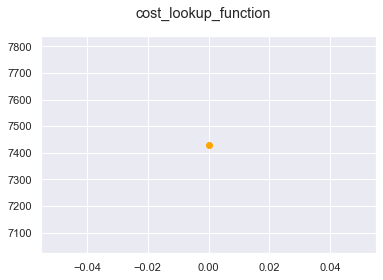

KeyError: 'cost_bind_name'

In [4]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_analysis_type_annotate', output)
estimate_plot(df, 'cost_analysis_type_check', output)
estimate_plot(df, 'cost_analysis_type_lookup', output)
estimate_plot(df, 'cost_analysis_visit', output)
estimate_plot(df, 'cost_analysis_iterable_func', output)
estimate_plot(df, 'cost_analysis_option_cons', output)
estimate_plot(df, 'cost_analysis_option_check', output)
estimate_plot(df, 'cost_analysis_bind_name', output)
estimate_plot(df, 'cost_analysis_list_items_check', output)
estimate_plot(df, 'cost_analysis_check_tuple_get', output, nlogn)
# estimate_plot(df, 'cost_analysis_check_tuple_merge ', output)
estimate_plot(df, 'cost_analysis_check_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_analysis_tuple_items_check', output)
estimate_plot(df, 'cost_analysis_check_let', output)
estimate_plot(df, 'cost_analysis_lookup_function', output)
estimate_plot(df, 'cost_analysis_lookup_function_types', output)
estimate_plot(df, 'cost_analysis_lookup_variable_const', output)
estimate_plot(df, 'cost_analysis_lookup_variable_depth', output, nlogn)
estimate_plot(df, 'cost_arithmetic_only_checker', output)
estimate_plot(df, 'cost_read_only', output)
estimate_plot(df, 'cost_trait_checker', output)
estimate_plot(df, 'cost_type_checker', output)
estimate_plot(df, 'cost_ast_parse', output)
estimate_plot(df, 'cost_ast_cycle_detection', output)
estimate_plot(df, 'cost_analysis_storage', output)
estimate_plot(df, 'cost_analysis_use_trait_entry', output)
estimate_plot(df, 'cost_analysis_get_function_entry', output)
# do we have a benchmark for this?
# estimate_plot(df, 'cost_analysis_fetch_contract_entry', output)
estimate_plot(df, 'cost_lookup_variable_depth', output)
estimate_plot(df, 'cost_lookup_variable_size', output)
estimate_plot(df, 'cost_lookup_function', output)
estimate_plot(df, 'cost_bind_name', output)
estimate_plot(df, 'cost_inner_type_check_cost', output)
estimate_plot(df, 'cost_user_function_application', output)
estimate_plot(df, 'cost_let', output)
estimate_plot(df, 'cost_if', output)
estimate_plot(df, 'cost_asserts', output)
estimate_plot(df, 'cost_map', output)
estimate_plot(df, 'cost_filter', output)
estimate_plot(df, 'cost_len', output)
estimate_plot(df, 'cost_element_at', output)
estimate_plot(df, 'cost_index_of', output)
estimate_plot(df, 'cost_fold', output)
estimate_plot(df, 'cost_list_cons', output)
estimate_plot(df, 'cost_type_parse_step', output)
estimate_plot(df, 'cost_tuple_get', output, nlogn)
estimate_plot(df, 'cost_tuple_merge', output)
estimate_plot(df, 'cost_tuple_cons', output, nlogn)
estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_mul', output)
estimate_plot(df, 'cost_div', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_int_cast', output)
estimate_plot(df, 'cost_mod', output)
estimate_plot(df, 'cost_pow', output)
estimate_plot(df, 'cost_sqrti', output)
estimate_plot(df, 'cost_log2', output)
estimate_plot(df, 'cost_xor', output)
estimate_plot(df, 'cost_not', output)
estimate_plot(df, 'cost_eq', output)
estimate_plot(df, 'cost_begin', output)
estimate_plot(df, 'cost_hash160', output)
estimate_plot(df, 'cost_sha256', output)
estimate_plot(df, 'cost_sha512', output)
estimate_plot(df, 'cost_sha512t256', output)
estimate_plot(df, 'cost_keccak256', output)
estimate_plot(df, 'cost_secp256k1recover', output)
estimate_plot(df, 'cost_secp256k1verify', output)
estimate_plot(df, 'cost_print', output)
estimate_plot(df, 'cost_some_cons', output)
estimate_plot(df, 'cost_ok_cons', output)
estimate_plot(df, 'cost_err_cons', output)
estimate_plot(df, 'cost_default_to', output)
estimate_plot(df, 'cost_unwrap_ret', output)
estimate_plot(df, 'cost_unwrap_err_or_ret', output)
estimate_plot(df, 'cost_is_okay', output)
estimate_plot(df, 'cost_is_none', output)
estimate_plot(df, 'cost_is_err', output)
estimate_plot(df, 'cost_is_some', output)
estimate_plot(df, 'cost_unwrap', output)
estimate_plot(df, 'cost_unwrap_err', output)
estimate_plot(df, 'cost_try_ret', output)
estimate_plot(df, 'cost_match', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_append', output)
estimate_plot(df, 'cost_concat', output)
estimate_plot(df, 'cost_as_max_len', output)
estimate_plot(df, 'cost_contract_call', output)
estimate_plot(df, 'cost_contract_of', output)
estimate_plot(df, 'cost_principal_of', output)
estimate_plot(df, 'cost_at_block', output)
estimate_plot(df, 'cost_load_contract', output)
estimate_plot(df, 'cost_create_map', output)
estimate_plot(df, 'cost_create_var', output)
estimate_plot(df, 'cost_create_nft', output)
estimate_plot(df, 'cost_create_ft', output)
estimate_plot(df, 'cost_fetch_entry', output)
estimate_plot(df, 'cost_set_entry', output)
estimate_plot(df, 'cost_fetch_var', output)
estimate_plot(df, 'cost_set_var', output)
estimate_plot(df, 'cost_contract_storage', output)
estimate_plot(df, 'cost_block_info', output)
estimate_plot(df, 'cost_stx_balance', output)
estimate_plot(df, 'cost_stx_transfer', output)
estimate_plot(df, 'cost_ft_mint', output)
estimate_plot(df, 'cost_ft_transfer', output)
estimate_plot(df, 'cost_ft_balance', output)
estimate_plot(df, 'cost_nft_mint', output)
estimate_plot(df, 'cost_nft_transfer', output)
estimate_plot(df, 'cost_nft_owner', output)
estimate_plot(df, 'cost_ft_get_supply', output)
estimate_plot(df, 'cost_ft_burn', output)
estimate_plot(df, 'cost_nft_burn', output)
estimate_plot(df, 'poison_microblock', output)

output

In [5]:
output.to_csv("cost_constants.csv")